In [1]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
final_daily = pd.read_csv('/floyd/input/electric_lstm/final_daily.csv')
final_daily['Datetime'] = pd.to_datetime(final_daily.loc[:,'Datetime'], infer_datetime_format=True)
final_daily = final_daily.set_index('Datetime')

In [3]:
def transform_dataset(data_in, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data_in) is list else data_in.shape[1]
    dff = pd.DataFrame(data_in)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('%s(t-%d)' % (data_in.columns[j], i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff["Global_active_power"].shift(-i))
        if i != 0:
            names.append("Global_active_power(t+%d)" % i)
        else:
            names.append("Global_active_power(t)")
    data_out = pd.concat(cols, axis=1)
    data_out.columns = names
    data_out.dropna(inplace=True)
    return data_out

In [13]:
from sklearn.metrics import mean_squared_error
model_list_2 = []
for lag_size in range(1, 30, 5):
    for i, x in enumerate(final_daily.columns[1:]):
        
        cols_to_drop = list(final_daily.columns[1:][i : len(final_daily.columns[1:])])
        reframed = transform_dataset(final_daily.drop(cols_to_drop, axis = 1), lag_size, 7)
        values = reframed.values

        n_train_time = 210
        train = values[:-n_train_time, :]
        test = values[-n_train_time:,:]

        train_X, train_y = train[:, :-7], train[:, -7:]
        test_X, test_y = test[:, :-7], test[:, -7:]
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        
        for dropout in np.arange(0.1, 1, 0.3):
            model = Sequential()
            model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
            model.add(Dropout(dropout))
            model.add(Dense(7))
            model.compile(loss='mean_squared_error', optimizer='adam')
            history = model.fit(train_X, train_y, 
                                epochs=200, batch_size=200, 
                                validation_data=(test_X, test_y), verbose=0, shuffle=False)

            yhat = model.predict(test_X)
            avg_7_mse = mean_squared_error(test_y, yhat, multioutput='raw_values')
            avg_mse = mean_squared_error(test_y, yhat)
            print("MSE %f dropped %d lag %d drop %f shape %d" % (avg_mse, len(cols_to_drop), lag_size,dropout, values.shape[1]))
    
            params = dict()
            params['n_drop'] = len(cols_to_drop)
            params['cols_drop'] = cols_to_drop
            params['lag_size'] = lag_size
            params['model'] = model
            params['history'] = history
            params['scaler'] = scaler
            params['avg_mse'] = avg_mse
            params['avg_7_mse'] = avg_7_mse
            params['dropout'] = dropout
            

            model_list_2.append(params)
        

MSE 29.309248 dropped 6 lag 1 drop 0.100000 shape 8
MSE 29.060083 dropped 6 lag 1 drop 0.400000 shape 8
MSE 28.271880 dropped 6 lag 1 drop 0.700000 shape 8
MSE 34.829564 dropped 5 lag 1 drop 0.100000 shape 9
MSE 34.532500 dropped 5 lag 1 drop 0.400000 shape 9
MSE 33.607731 dropped 5 lag 1 drop 0.700000 shape 9
MSE 34.017000 dropped 4 lag 1 drop 0.100000 shape 10
MSE 33.814788 dropped 4 lag 1 drop 0.400000 shape 10
MSE 32.902354 dropped 4 lag 1 drop 0.700000 shape 10
MSE 29.827248 dropped 3 lag 1 drop 0.100000 shape 11
MSE 29.561913 dropped 3 lag 1 drop 0.400000 shape 11
MSE 28.858967 dropped 3 lag 1 drop 0.700000 shape 11
MSE 30.028594 dropped 2 lag 1 drop 0.100000 shape 12
MSE 29.857597 dropped 2 lag 1 drop 0.400000 shape 12
MSE 29.239877 dropped 2 lag 1 drop 0.700000 shape 12
MSE 30.616455 dropped 1 lag 1 drop 0.100000 shape 13
MSE 30.530259 dropped 1 lag 1 drop 0.400000 shape 13
MSE 29.742208 dropped 1 lag 1 drop 0.700000 shape 13
MSE 23.571576 dropped 6 lag 6 drop 0.100000 shape 13

In [16]:
model_list_2.sort(key = lambda x: x['avg_mse'])

In [45]:
check_model = model_list_2[0]

from joblib import dump, load
dump(check_model['model'], 'final_model/model.joblib')
dump(check_model['scaler'], 'final_model/scaler.joblib')
dump(check_model['history'], 'final_model/history.joblib')


['final_model/history.joblib']

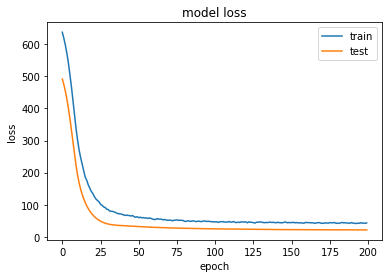

In [18]:
plt.plot(check_model['history'].history['loss'])
plt.plot(check_model['history'].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [19]:
pd.DataFrame([{'n_drop': i['n_drop'],
 'cols_drop': i['cols_drop'], 
 'lag_size': i['lag_size'], 
 'avg_mse': i['avg_mse'],
 'avg_7_mse': i['avg_7_mse'],
 'dropout': i['dropout']} for i in model_list_2]).to_csv("scores_final.csv")

In [46]:
# model_list_labeled = old_list.copy()
df_scores = []
for index, i in enumerate(model_list_2):
    df_scores.append(pd.DataFrame({"train" : i['history'].history['loss'],
                     "test" : i['history'].history['val_loss'],
                     "train" : i['history'].history['loss'],
                     "mse" : i["avg_mse"],
                     "id" : index,
                     "row" : range(0, len(i['history'].history['val_loss']))}))

In [47]:
pd.concat(df_scores).to_csv("model_scores.csv")

In [44]:
for index, check_model in enumerate(model_list_2):
    data = transform_dataset(final_daily.drop(check_model['cols_drop'], axis = 1), check_model['lag_size'], 1)
    test_X, test_y = data.values[:, :-1], data.values[:, -1:]

    scaler = check_model['scaler']
    test_X = scaler.transform(test_X)

    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    model = check_model['model']
    yhat = model.predict(test_X)
    pd.DataFrame({"y_hat" : yhat[:,0], 'y_true' : test_y.flatten()}, index = data.index).\
        to_csv('all_models/%d_model_est.csv' % index)


In [55]:
check_model = model_list_2[0]
data = transform_dataset(final_daily.drop(check_model['cols_drop'], axis = 1), check_model['lag_size'], 0)
test_X = data.values

scaler = check_model['scaler']
test_X = scaler.transform(test_X)

test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
model = check_model['model']
yhat = model.predict(test_X)
pd.Series(yhat[-1]).to_csv('final_model/final_prediction.csv')